<a href="https://colab.research.google.com/github/badbloody/diploma2023/blob/main/my_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importing the needed libraries here:

In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import random
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import shutil
from glob import glob

import numpy as np
import multiprocessing

import copy
from tqdm import tqdm
from collections import defaultdict

import torch.utils.data.distributed
import time

from pprint import pprint
display = pprint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]
tensor_normalizer = transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
epsilon = 1e-5

def preprocess_image(image, target_width=None):
    """ input PIL.Image, return a normalized four-dimensional tensor """
    if target_width:
        t = transforms.Compose([
            transforms.Resize(target_width),
            transforms.CenterCrop(target_width),
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    else:
        t = transforms.Compose([
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    return t(image).unsqueeze(0)


def image_to_tensor(image, target_width=None):
    """ input OpenCV image, range 0~255, BGR order, return a normalized four-dimensional tensor """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    return preprocess_image(image, target_width)


def read_image(path, target_width=None):
    image = Image.open(path)
    return preprocess_image(image, target_width)


def recover_image(tensor):
    """ input a four-dimensional tensor on the GPU, return a three-dimensional numpy matrix in the range of 0~255, RGB orde r"""
    image = tensor.detach().cpu().numpy()
    image = image * np.array(cnn_normalization_std).reshape((1, 3, 1, 1)) + \
    np.array(cnn_normalization_mean).reshape((1, 3, 1, 1))
    return (image.transpose(0, 2, 3, 1) * 255.).clip(0, 255).astype(np.uint8)[0]


def recover_tensor(tensor):
    m = torch.tensor(cnn_normalization_mean).view(1, 3, 1, 1).to(tensor.device)
    s = torch.tensor(cnn_normalization_std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * s + m
    return tensor.clamp(0, 1)


def imshow(tensor, title=None):
    """ input into a 4D tensor on the GPU, then draw the image """
    image = recover_image(tensor)
    print(image.shape)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


def mean_std(features):
    """ input the features (4) calculated by VGG16, return the mean and standard deviation of each feature map (the length is 1920) """
    mean_std_features = []
    for x in features:
        x = x.view(*x.shape[:2], -1)
        x = torch.cat([x.mean(-1), torch.sqrt(x.var(-1) + epsilon)], dim=-1)
        n = x.shape[0]
        x2 = x.view(n, 2, -1).transpose(2, 1).contiguous().view(n, -1) # 【mean, ..., std, ...] to [mean, std, ...]
        mean_std_features.append(x2)
    mean_std_features = torch.cat(mean_std_features, dim=-1)
    return mean_std_features


class Smooth:
    # perform a moving average on the input data
    def __init__(self, windowsize=100):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size, 1), dtype=np.float32)
        self.index = 0

    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self

    def __float__(self):
        return float(self.data.mean())

    def __format__(self, f):
        return self.__float__().__format__(f)

In [ ]:
class VGG(nn.Module):

    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        outs = []
        for name, module in self.features._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                outs.append(x)
        return outs


class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(MyConv2D, self).__init__()
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = torch.zeros(out_channels).to(device)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        return s.format(**self.__dict__)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1),
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x


def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1,
    upsample=None, instance_norm=True, relu=True, trainable=False):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    if trainable:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    else:
        layers.append(MyConv2D(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers


class TransformNet(nn.Module):
    def __init__(self, base=8):
        super(TransformNet, self).__init__()
        self.base = base
        self.weights = []
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9, trainable=True),
            *ConvLayer(base, base*2, kernel_size=3, stride=2),
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2),
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False, trainable=True),
        )
        self.get_param_dict()

    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

    def get_param_dict(self):
        """ find all MyConv2D layers of the network and calculate the number of weights they need """
        param_dict = defaultdict(int)
        def dfs(module, name):
            for name2, layer in module.named_children():
                dfs(layer, '%s.%s' % (name, name2) if name != '' else name2)
            if module.__class__ == MyConv2D:
                param_dict[name] += int(np.prod(module.weight.shape))
                param_dict[name] += int(np.prod(module.bias.shape))
        dfs(self, '')
        return param_dict

    def set_my_attr(self, name, value):
        """ traverse a string similar to residuals.0.conv.1 step by step to find the corresponding weight """
        target = self
        for x in name.split('.'):
            if x.isnumeric():
                target = target.__getitem__(int(x))
            else:
                target = getattr(target, x)

        # assign the corresponding weight
        n_weight = np.prod(target.weight.shape)
        target.weight = value[:n_weight].view(target.weight.shape)
        target.bias = value[n_weight:].view(target.bias.shape)

    def set_weights(self, weights, i=0):
        """ input a weight dictionary, set weights for all MyConv2D layers of the network"""
        for name, param in weights.items():
            self.set_my_attr(name, weights[name][i])

    def reset_weights(self):
        """ reset the weights of a network """
        for name, param in self.named_children():
            if isinstance(param, MyConv2D):
                with torch.no_grad():
                    weight_size = int(np.prod(param.weight.shape))
                    bias_size = int(np.prod(param.bias.shape))
                    initial_weights = torch.randn(weight_size + bias_size)
                    self.set_my_attr(name, initial_weights)

class MetaNet(nn.Module):
    def __init__(self, param_dict):
        super(MetaNet, self).__init__()
        self.param_num = len(param_dict)
        self.hidden = nn.Linear(1920, 128*self.param_num)
        self.fc_dict = {}
        for i, (name, params) in enumerate(param_dict.items()):
            self.fc_dict[name] = i
            setattr(self, 'fc{}'.format(i+1), nn.Linear(128, params))

    def forward(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return filters

In [ ]:
is_hvd = False
base = 32
# style_weight = 50 #first training

style_weight = 25

content_weight = 1
tv_weight = 1e-6
epochs = 10

batch_size = 8
width = 256

verbose_hist_batch = 100
verbose_image_batch = 800

model_name = f'metanet_base{base}_style{style_weight}_tv{tv_weight}'

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:22<00:00, 24.9MB/s]


In [ ]:
transform_net = TransformNet(base).to(device)
transform_net.get_param_dict()

defaultdict(int,
            {'downsampling.5': 18496,
             'downsampling.9': 73856,
             'residuals.0.conv.1': 147584,
             'residuals.0.conv.5': 147584,
             'residuals.1.conv.1': 147584,
             'residuals.1.conv.5': 147584,
             'residuals.2.conv.1': 147584,
             'residuals.2.conv.5': 147584,
             'residuals.3.conv.1': 147584,
             'residuals.3.conv.5': 147584,
             'residuals.4.conv.1': 147584,
             'residuals.4.conv.5': 147584,
             'upsampling.2': 73792,
             'upsampling.7': 18464})

In [ ]:
metanet = MetaNet(transform_net.get_param_dict()).to(device)

In [ ]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(width, scale=(256/480, 1), ratio=(1, 1)),
    transforms.ToTensor(),
    tensor_normalizer
])

content_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/content_dataset_train', transform=data_transform)
style_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/style_dataset_train', transform=data_transform)

In [ ]:
content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())

In [ ]:
print(style_dataset)
print('-'*20)
print(content_dataset)

Dataset ImageFolder
    Number of datapoints: 31
    Root location: /content/gdrive/MyDrive/style_dataset_train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.5333, 1), ratio=(1, 1), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
--------------------
Dataset ImageFolder
    Number of datapoints: 9899
    Root location: /content/gdrive/MyDrive/content_dataset_train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.5333, 1), ratio=(1, 1), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
metanet.eval()
transform_net.eval()

rands = torch.rand(4, 3, 256, 256).to(device)
features = vgg16(rands);
weights = metanet(mean_std(features));
transform_net.set_weights(weights)
transformed_images = transform_net(torch.rand(4, 3, 256, 256).to(device));

In [ ]:
trainable_params = {}
trainable_param_shapes = {}
for model in [vgg16, transform_net, metanet]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params[name] = param
            trainable_param_shapes[name] = param.shape

In [ ]:
optimizer = optim.Adam(trainable_params.values(), 1e-3)

In [ ]:
n_batch = len(content_data_loader)
metanet.train()
transform_net.train()

TransformNet(
  (downsampling): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): MyConv2D(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): ReLU()
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): MyConv2D(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (10): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): ReLU()
  )
  (residuals): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): MyConv2D(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU()
        (4): Re

In [ ]:
os.makedirs('/content/gdrive/MyDrive/myOwnModels_2')

In [ ]:
for epoch in range(epochs):
    smoother = defaultdict(Smooth)
    with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
        for batch, (content_images, _) in pbar:
            n_iter = epoch*n_batch + batch

            # randomly select a new style image every 20 batches
            # we might change this for experiments as well
            if batch % 20 == 0:
                style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
                style_features = vgg16(style_image)
                style_mean_std = mean_std(style_features)

            # check for a solid color
            x = content_images.cpu().numpy()
            if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
                continue

            optimizer.zero_grad()

            # generate style models using style images
            weights = metanet(mean_std(style_features))
            transform_net.set_weights(weights, 0)

            # using Style Models to Predict Style Transferred Images
            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)

            # compute features using vgg16
            content_features = vgg16(content_images)
            transformed_features = vgg16(transformed_images)
            transformed_mean_std = mean_std(transformed_features)

            # content loss
            content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

            # style loss
            style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                                   style_mean_std.expand_as(transformed_mean_std))

            # total variation loss
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                    torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            # sumarized loss
            loss = content_loss + style_loss + tv_loss

            loss.backward()
            optimizer.step()

            smoother['content_loss'] += content_loss.item()
            smoother['style_loss'] += style_loss.item()
            smoother['tv_loss'] += tv_loss.item()
            smoother['loss'] += loss.item()

            max_value = max([x.max().item() for x in weights.values()])

            s = 'Epoch: {} '.format(epoch+1)
            s += 'Content: {:.2f} '.format(smoother['content_loss'])
            s += 'Style: {:.1f} '.format(smoother['style_loss'])
            s += 'Loss: {:.2f} '.format(smoother['loss'])
            s += 'Max: {:.2f}'.format(max_value)

            pbar.set_description(s)
            del transformed_images, weights

    torch.save(metanet.state_dict(), '/content/gdrive/MyDrive/myOwnModels_2/{}.pth'.format(model_name))
    torch.save(transform_net.state_dict(), '/content/gdrive/MyDrive/myOwnModels_2/{}_transform_net.pth'.format(model_name))

Epoch: 1 Content: 17.14 Style: 19.8 Loss: 37.60 Max: 233.95: 100%|██████████| 1238/1238 [1:01:59<00:00,  3.00s/it]
Epoch: 2 Content: 13.95 Style: 13.7 Loss: 27.97 Max: 285.41: 100%|██████████| 1238/1238 [10:21<00:00,  1.99it/s]
Epoch: 3 Content: 16.00 Style: 23.1 Loss: 39.60 Max: 1214.99: 100%|██████████| 1238/1238 [10:19<00:00,  2.00it/s]
Epoch: 4 Content: 16.24 Style: 18.1 Loss: 34.98 Max: 848.94: 100%|██████████| 1238/1238 [10:16<00:00,  2.01it/s]
Epoch: 5 Content: 15.07 Style: 16.8 Loss: 32.44 Max: 2190.78: 100%|██████████| 1238/1238 [10:18<00:00,  2.00it/s]
Epoch: 6 Content: 16.11 Style: 18.1 Loss: 34.91 Max: 1751.37: 100%|██████████| 1238/1238 [10:18<00:00,  2.00it/s]
Epoch: 7 Content: 14.20 Style: 14.5 Loss: 29.17 Max: 2316.74: 100%|██████████| 1238/1238 [10:18<00:00,  2.00it/s]
Epoch: 8 Content: 16.90 Style: 15.2 Loss: 32.81 Max: 3563.86: 100%|██████████| 1238/1238 [10:19<00:00,  2.00it/s]
Epoch: 9 Content: 12.84 Style: 10.3 Loss: 23.76 Max: 1964.21: 100%|██████████| 1238/1238 

In [ ]:
os.makedirs("/content/gdrive/MyDrive/myOwnModels")

21it [00:09,  2.20it/s]


(256, 256, 3)
(256, 2048, 3)
(256, 2048, 3)


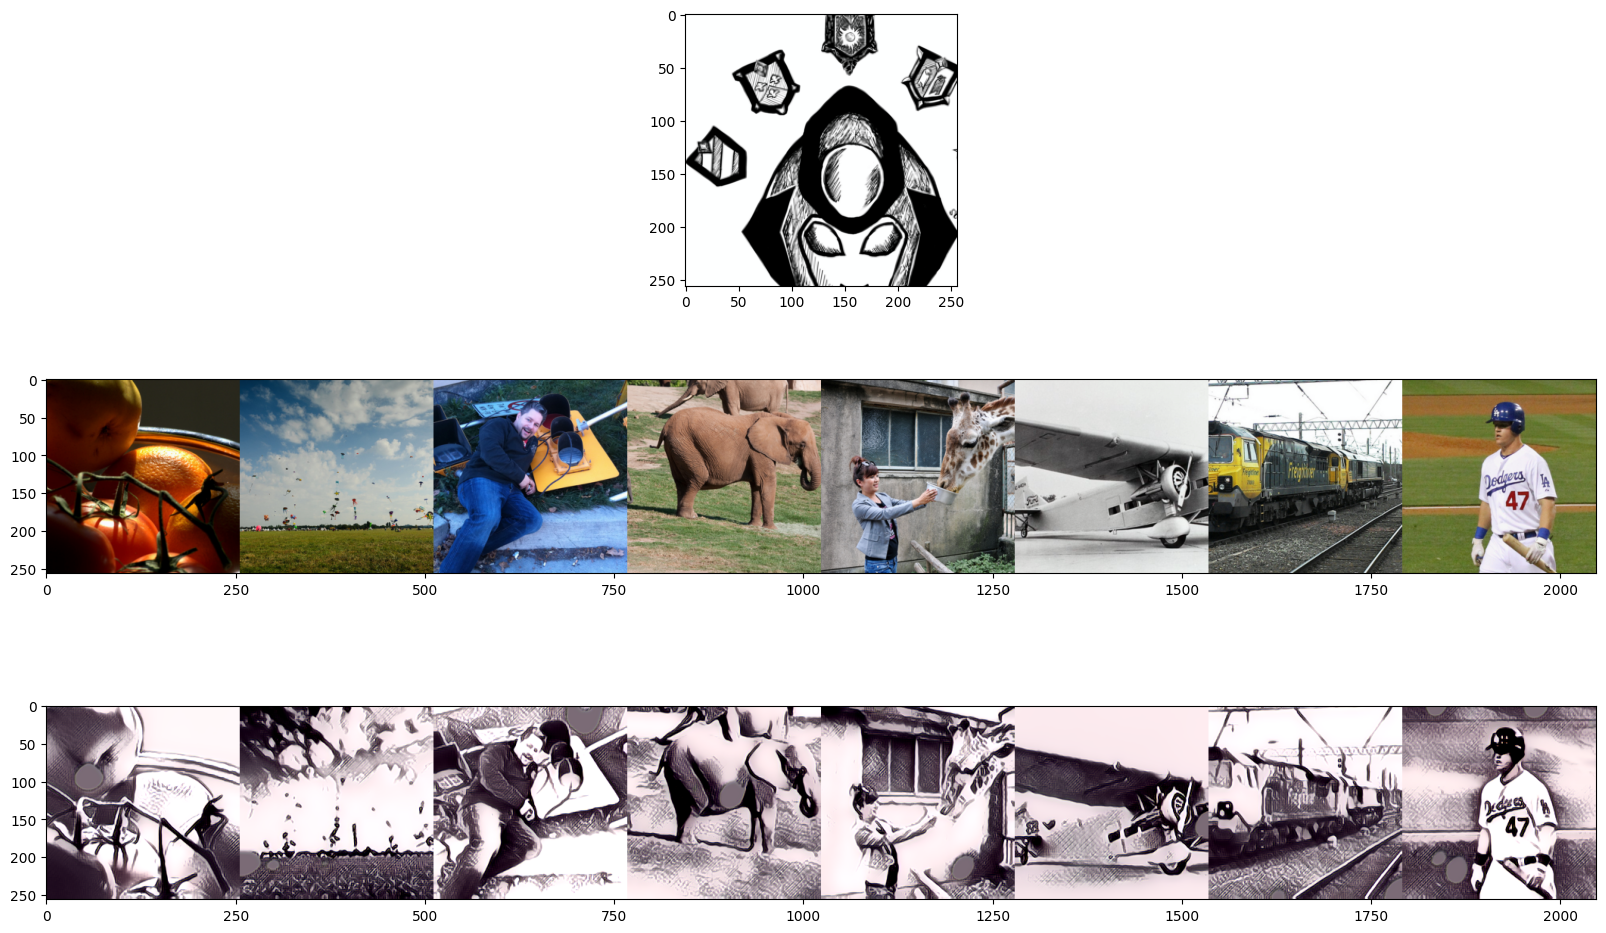

In [ ]:
content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)

#style_image = torch.stack([random.choice(style_dataset)[0] for i in range(1)]).to(device)
style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

n_batch = 20
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue

        optimizer.zero_grad()

        weights = metanet.forward(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        # content loss
        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

        # style loss
        style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                               style_mean_std.expand_as(transformed_mean_std))

        # total variation loss
        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        # 求和
        loss = content_loss + style_loss + tv_loss

        loss.backward()
        optimizer.step()

        if batch > n_batch:
            break



transformed_images = transform_net(content_images)

transformed_images_vis = torch.cat([x for x in transformed_images], dim=-1)
content_images_vis = torch.cat([x for x in content_images], dim=-1)


plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)

21it [00:09,  2.20it/s]


(256, 256, 3)
(256, 2048, 3)
(256, 2048, 3)


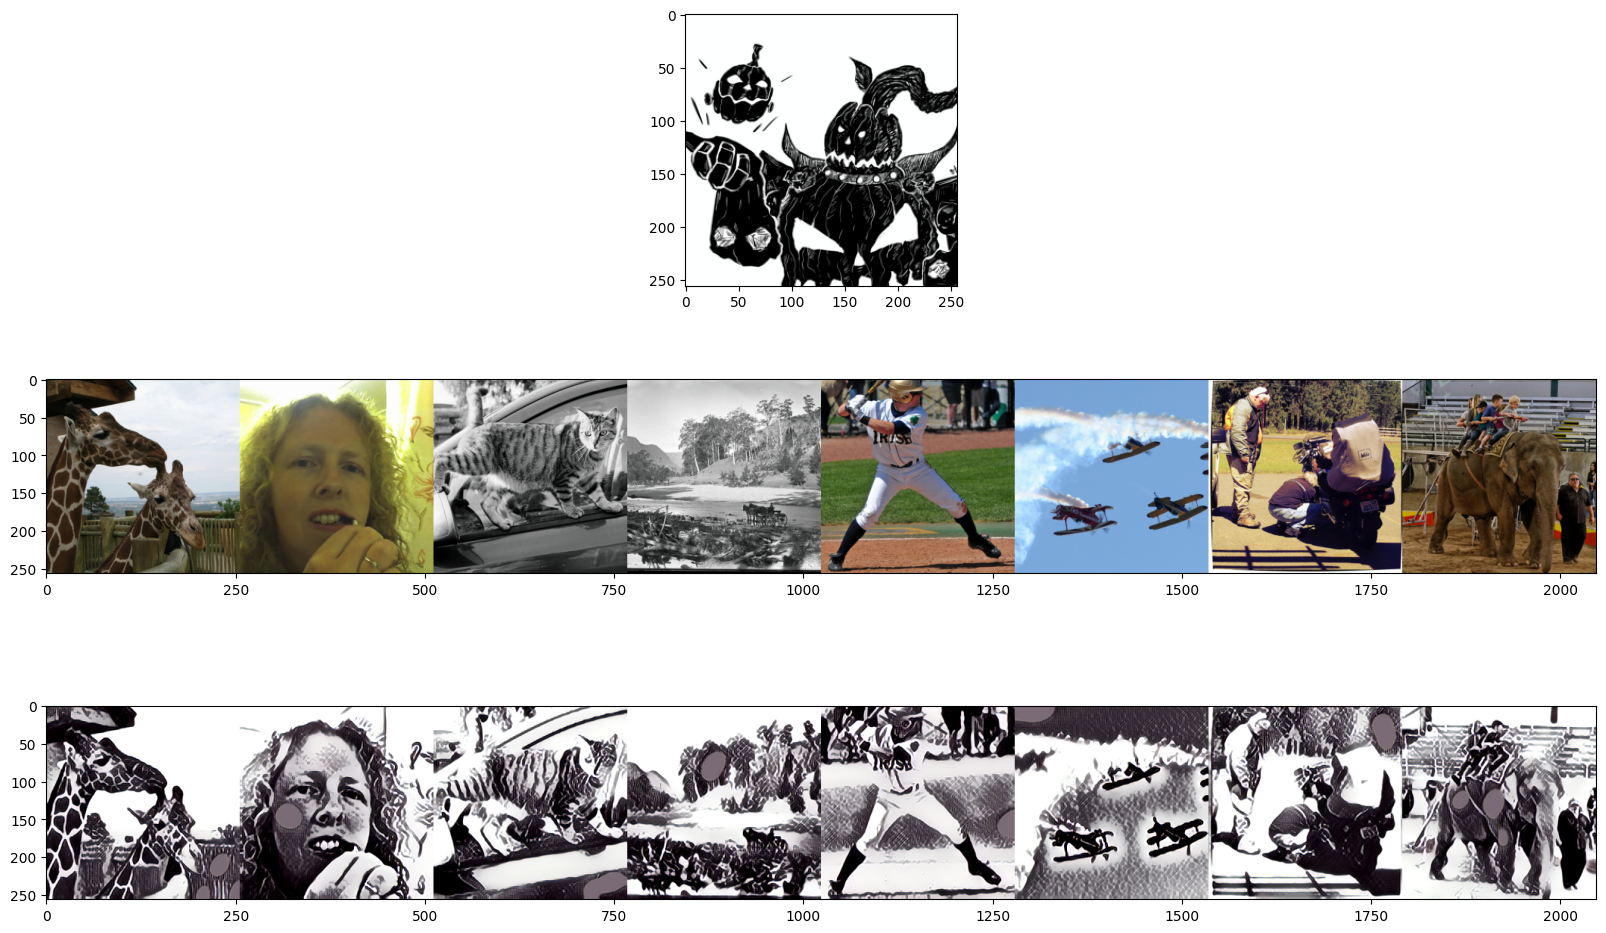

In [ ]:
content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)

style_image = random.choice(style_dataset)[0].unsqueeze(0).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

transform_net.reset_weights()

n_batch = 20
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue

        optimizer.zero_grad()

        weights = metanet.forward(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        # content loss
        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

        # style loss
        style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                               style_mean_std.expand_as(transformed_mean_std))

        # total variation loss
        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        # 求和
        loss = content_loss + style_loss + tv_loss

        loss.backward()
        optimizer.step()

        if batch > n_batch:
            break



transformed_images = transform_net(content_images)

transformed_images_vis = torch.cat([x for x in transformed_images], dim=-1)
content_images_vis = torch.cat([x for x in content_images], dim=-1)


plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)

51it [00:22,  2.26it/s]


(256, 256, 3)
(256, 2048, 3)
(256, 2048, 3)


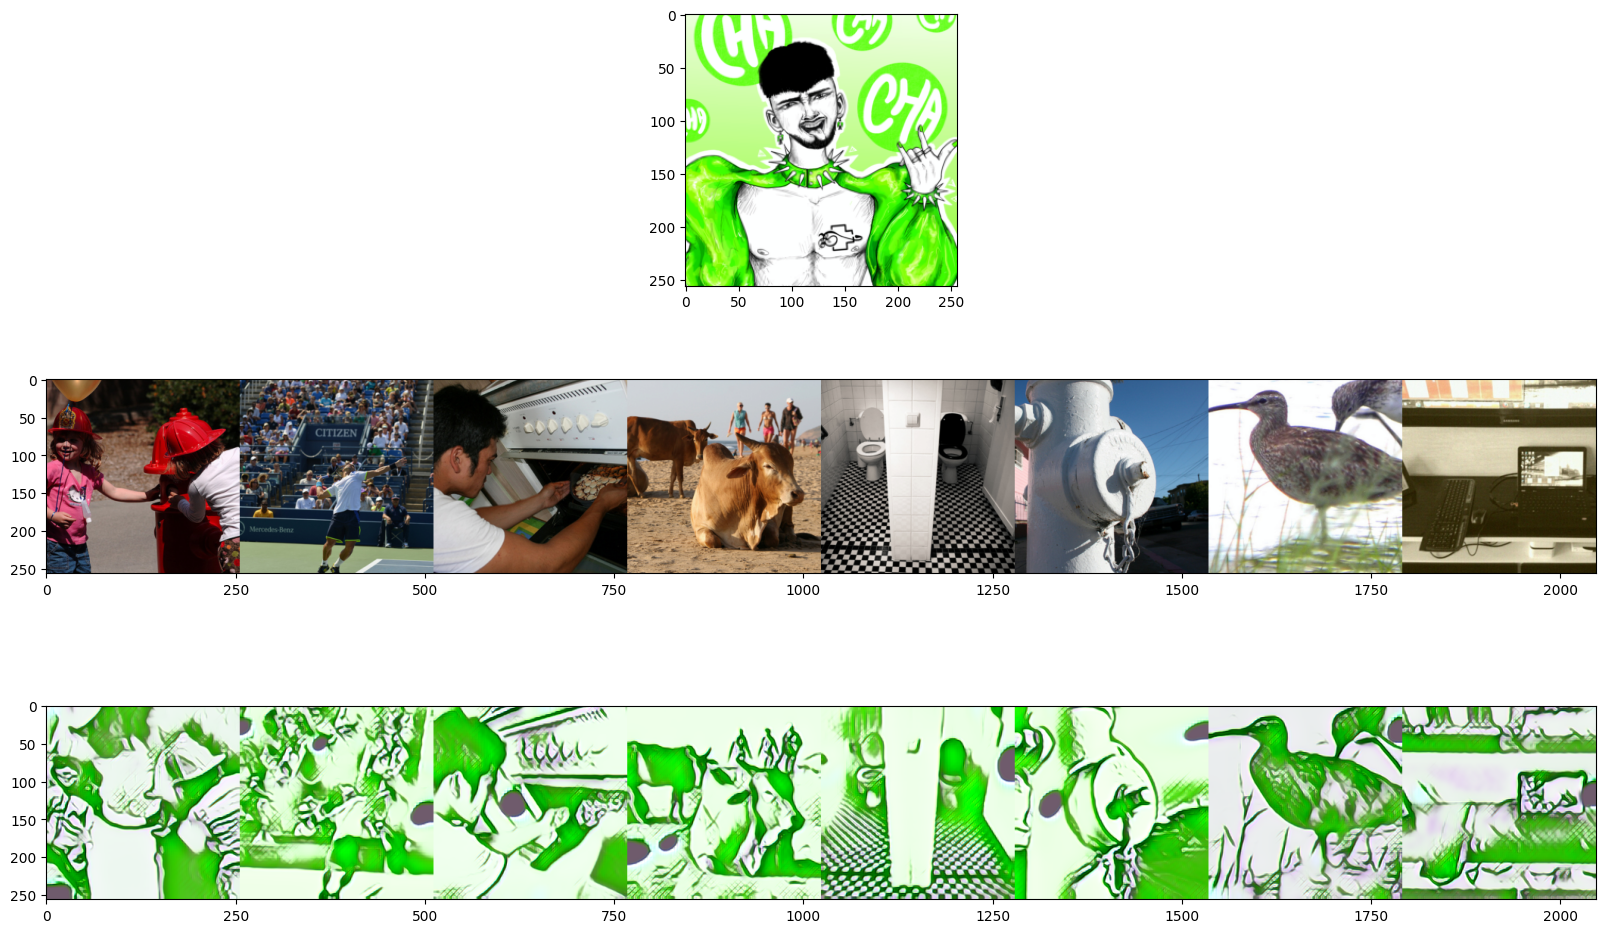

In [ ]:
content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)

style_image = torch.stack([random.choice(style_dataset)[0] for i in range(1)]).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

n_batch = 50
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue

        optimizer.zero_grad()

        weights = metanet.forward(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        # content loss
        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

        # style loss
        style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                               style_mean_std.expand_as(transformed_mean_std))

        # total variation loss
        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        # 求和
        loss = content_loss + style_loss + tv_loss

        loss.backward()
        optimizer.step()

        if batch > n_batch:
            break



transformed_images = transform_net(content_images)

transformed_images_vis = torch.cat([x for x in transformed_images], dim=-1)
content_images_vis = torch.cat([x for x in content_images], dim=-1)


plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)

101it [00:44,  2.25it/s]


(256, 256, 3)
(256, 2048, 3)
(256, 2048, 3)


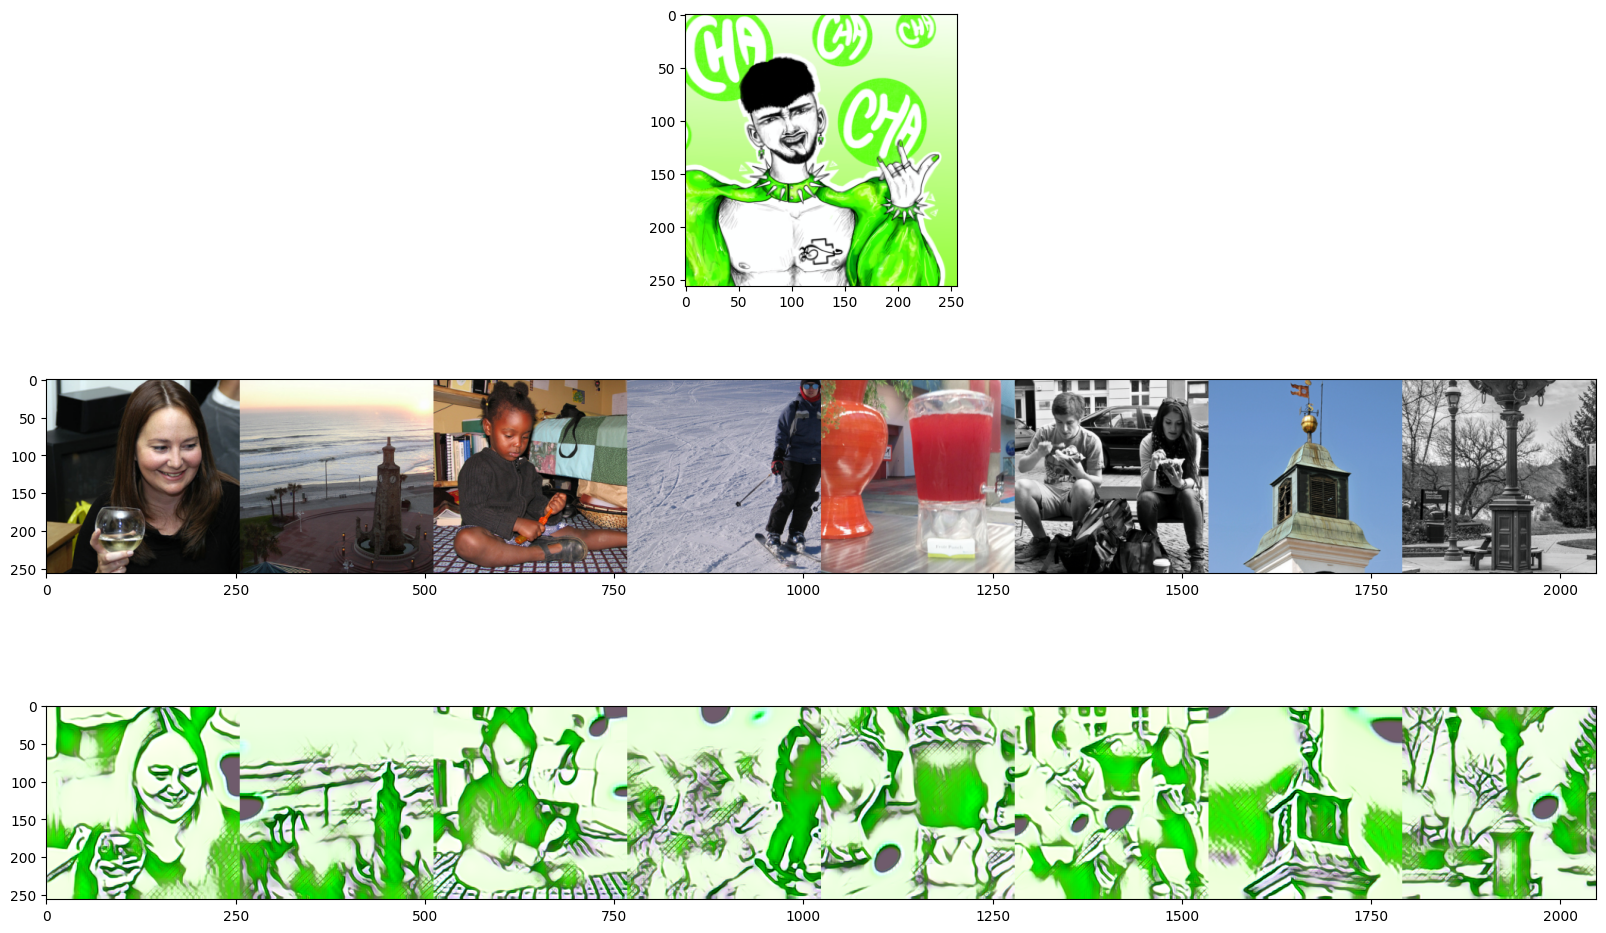

In [ ]:
content_images = torch.stack([random.choice(content_dataset)[0] for i in range(4)]).to(device)

style_image = torch.stack([random.choice(style_dataset)[0] for i in range(1)]).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

n_batch = 100
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue

        optimizer.zero_grad()

        weights = metanet.forward(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        # content loss
        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

        # style loss
        style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                               style_mean_std.expand_as(transformed_mean_std))

        # total variation loss
        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        # 求和
        loss = content_loss + style_loss + tv_loss

        loss.backward()
        optimizer.step()

        if batch > n_batch:
            break



transformed_images = transform_net(content_images)

transformed_images_vis = torch.cat([x for x in transformed_images], dim=-1)
content_images_vis = torch.cat([x for x in content_images], dim=-1)


plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)

In [ ]:
os.makedirs("/content/gdrive/MyDrive/outputImages")

In [ ]:
from PIL import Image

for index, image_obj in enumerate(transformed_images):
    print(image_obj.shape)
    numpy_image = image_obj.cpu().detach().numpy()
    print(numpy_image.shape)
    pil_image = Image.fromarray(numpy_image)

    filename = f"/content/gdrive/MyDrive/outputImages/image_{index}.png"  # You can adjust the filename as needed
    pil_image.save(filename)
    print(f"Image saved as {filename}")

torch.Size([3, 256, 256])
(3, 256, 256)


TypeError: ignored

In [ ]:
import torch
from PIL import Image
import os

# Example list of tensor images (replace this with your actual data)
tensor_images = transformed_images

# Specify the folder where you want to save the images
output_folder = "/content/gdrive/MyDrive/outputImages_2"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

for index, tensor_image in enumerate(tensor_images):
    # Convert the tensor to a NumPy array and denormalize
    numpy_image = tensor_image.detach().cpu().numpy()
    numpy_image = (numpy_image + 1.0) / 2.0  # Revert [-1, 1] normalization

    # Transpose the NumPy array to match Pillow's expected format (H, W, C)
    numpy_image = np.transpose(numpy_image, (1, 2, 0))

    # Convert the NumPy array to a Pillow image
    pil_image = Image.fromarray((numpy_image * 255).astype('uint8'), mode='RGB')

    # Save the Pillow image to the specified folder
    filename = os.path.join(output_folder, f"image_{index}.png")
    pil_image.save(filename)
    print(f"Image saved as {filename}")

Image saved as /content/gdrive/MyDrive/outputImages_2/image_0.png
Image saved as /content/gdrive/MyDrive/outputImages_2/image_1.png
Image saved as /content/gdrive/MyDrive/outputImages_2/image_2.png
Image saved as /content/gdrive/MyDrive/outputImages_2/image_3.png
Image saved as /content/gdrive/MyDrive/outputImages_2/image_4.png
Image saved as /content/gdrive/MyDrive/outputImages_2/image_5.png
Image saved as /content/gdrive/MyDrive/outputImages_2/image_6.png
Image saved as /content/gdrive/MyDrive/outputImages_2/image_7.png


In [ ]:
def save_transformed_images(transformed_image, filename):
    """ a function to save an image to a file """
    transformed_image = recover_image(transformed_image)
    pil_image = Image.fromarray(transformed_image)
    pil_image.save(filename)

In [ ]:
# Example list of tensor images (replace this with your actual data)
tensor_images = transformed_images

# Specify the folder where you want to save the images
output_folder = "/content/gdrive/MyDrive/outputImages_25style_sketch"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

for index, tensor_image in enumerate(tensor_images):
    # Convert the tensor to a NumPy array and denormalize
    #numpy_image = tensor_image.detach().cpu().numpy()
    #numpy_image = (numpy_image + 1.0) / 2.0  # Revert [-1, 1] normalization

    # Transpose the NumPy array to match Pillow's expected format (H, W, C)
    #numpy_image = np.transpose(numpy_image, (1, 2, 0))

    # Convert the NumPy array to a Pillow image
    #pil_image = Image.fromarray((numpy_image * 255).astype('uint8'), mode='RGB')

    # Save the Pillow image to the specified folder
    filename = os.path.join(output_folder, f"image_{index}.png")
    #pil_image.save(filename)

    save_transformed_images(tensor_image, filename)
    print(f"Image saved as {filename}")

Image saved as /content/gdrive/MyDrive/outputImages_25style_sketch/image_0.png
Image saved as /content/gdrive/MyDrive/outputImages_25style_sketch/image_1.png
Image saved as /content/gdrive/MyDrive/outputImages_25style_sketch/image_2.png
Image saved as /content/gdrive/MyDrive/outputImages_25style_sketch/image_3.png
Image saved as /content/gdrive/MyDrive/outputImages_25style_sketch/image_4.png
Image saved as /content/gdrive/MyDrive/outputImages_25style_sketch/image_5.png
Image saved as /content/gdrive/MyDrive/outputImages_25style_sketch/image_6.png
Image saved as /content/gdrive/MyDrive/outputImages_25style_sketch/image_7.png


In [ ]:
output_folder = "/content/gdrive/MyDrive/outputImages_25style_content"

for index, tensor_image in enumerate(content_images):
    filename = os.path.join(output_folder, f"image_{index}.png")
    save_transformed_images(tensor_image, filename)
    print(f"Image saved as {filename}")